U0 of hyrogen: -13.61 eV
U0 of carbon: -1029.86 eV
U0 of oxygen: -2042.61 eV
Mean atomization energy / atom: tensor([-4.2464])
Std. dev. atomization energy / atom: tensor([0.1962])
Final validation MAE: 1.47 eV = 34.0 kcal/mol


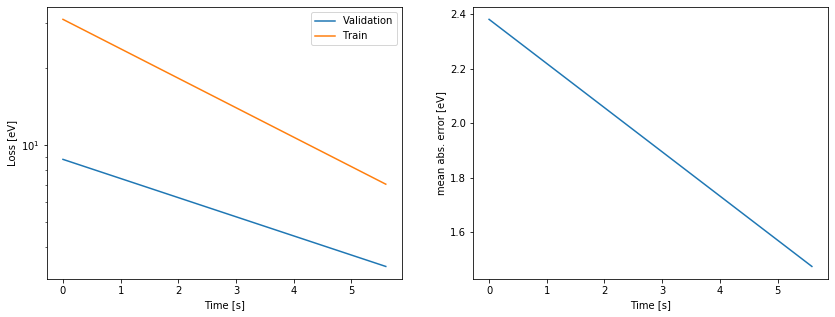

In [3]:
# Train a SchNet model and store the outcome in ./trained_models/qm916/best_model

import os
import schnetpack as spk
import torch
import schnetpack.nn 
import schnetpack.data


## Step 1 define the model

#prepare directory for the output of the best model after training
qm916 = './trained_models/qm916'
if not os.path.exists('./trained_models/qm916'):
    os.makedirs(qm916)

# Download QM9 data set used for training and validation    

from schnetpack.datasets import QM9


qm9data = QM9('./qm9.db', download=True, remove_uncharacterized=True)

# Define the number of training data and the number of validation data using split module

train, val, test = spk.train_test_split(
        data=qm9data,
        num_train=1000,
        num_val=500,
        split_file=os.path.join(qm916, "split.npz"),
    )

# Define the loaders of training data and validation data and batch size

train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=100)

# Get reference atom data

atomrefs = qm9data.get_atomref(QM9.U0)
print('U0 of hyrogen:', '{:.2f}'.format(atomrefs[QM9.U0][1][0]), 'eV')
print('U0 of carbon:', '{:.2f}'.format(atomrefs[QM9.U0][6][0]), 'eV')
print('U0 of oxygen:', '{:.2f}'.format(atomrefs[QM9.U0][8][0]), 'eV')


means, stddevs = train_loader.get_statistics(
    QM9.U0, divide_by_atoms=True, single_atom_ref=atomrefs)


print('Mean atomization energy / atom:', means[QM9.U0])
print('Std. dev. atomization energy / atom:', stddevs[QM9.U0])

# Define SchNet embedding representation model

schnet = spk.representation.SchNet(
    n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=6,
    cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
)

# Define output model and property to be predicted

output_U0 = spk.atomistic.Atomwise(n_in=30, atomref=atomrefs[QM9.U0], property=QM9.U0,
                                   mean=means[QM9.U0], contributions=True, stddev=stddevs[QM9.U0])
model = spk.AtomisticModel(representation=schnet, output_modules=output_U0)

## Training and Validation 
# NOTE You must delete previous best_model if you want to restart the training!

from torch.optim import Adam

# loss function
def mse_loss(batch, result):
    diff = batch[QM9.U0]-result[QM9.U0]
    err_sq = torch.mean(diff ** 2)
    return err_sq

# build optimizer
optimizer = Adam(model.parameters(), lr=1e-2)


import schnetpack.train as trn

loss = trn.build_mse_loss([QM9.U0])

metrics = [spk.metrics.MeanAbsoluteError(QM9.U0)]
hooks = [
    trn.CSVHook(log_path=qm916, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path=qm916,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

device = "cpu" # change to 'cpu' if gpu is not available
n_epochs = 1 # takes about 10 min on a notebook GPU. reduces for playing around
trainer.train(device=device, n_epochs=n_epochs)

import numpy as np
import matplotlib.pyplot as plt
from ase.units import kcal, mol

results = np.loadtxt(os.path.join(qm916, 'log.csv'), skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final validation MAE:', np.round(val_mae[-1], 2), 'eV =',
      np.round(val_mae[-1] / (kcal/mol), 2), 'kcal/mol')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [eV]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [eV]')
plt.xlabel('Time [s]')
plt.show()

